In [4]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


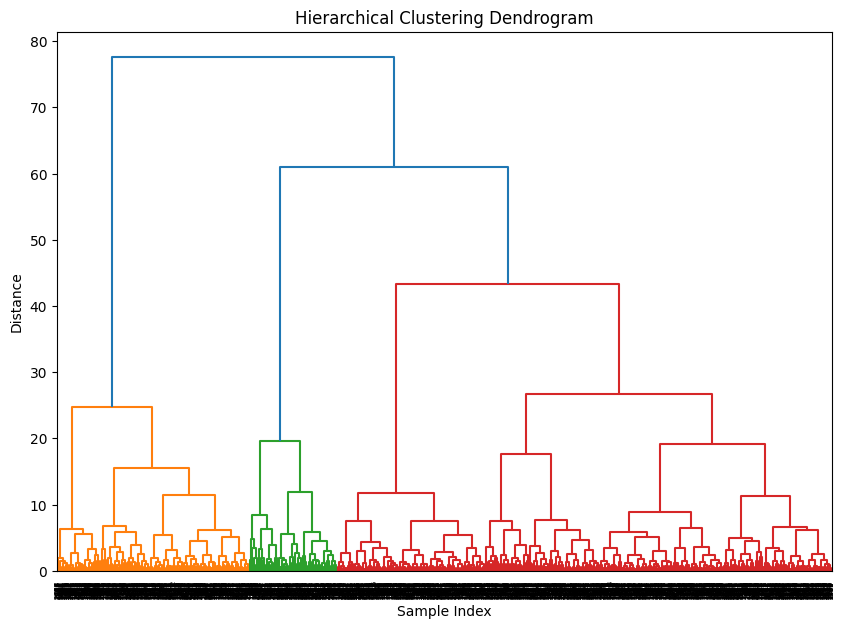


Cluster Characteristics:
         Recency  Frequency  Monetary  Average_Order_Value    Category
Cluster                                                               
0        3776.91       5.28     42.03                 8.16  Fresh Food
1        3443.04      11.79     99.25                 8.71  Fresh Food
2        3449.36      19.55    187.69                 9.87  Fresh Food
3        3477.55       5.74     42.41                 7.69  Fresh Food
4        3623.27      11.98    104.86                 9.00  Fresh Food

Category Distribution within Clusters:

Cluster 0:
Category
Fresh Food    395
Dairy         128
Beverages      83
Name: count, dtype: int64

Cluster 1:
Category
Fresh Food    486
Dairy         144
Beverages     101
Name: count, dtype: int64

Cluster 3:
Category
Fresh Food    300
Dairy         112
Beverages      62
Name: count, dtype: int64

Cluster 4:
Category
Fresh Food         217
Dairy               90
Bakery & Sweets     48
Name: count, dtype: int64

Cluster 2:
Catego

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage

# Load all datasets
rfm_df = pd.read_csv('/content/gdrive/.shortcut-targets-by-id/1KCLOFbsop0lTMWeXeVuopEz0IZW_1NVJ/Project1/rfm.csv')
transactions_df = pd.read_csv('/content/gdrive/.shortcut-targets-by-id/1KCLOFbsop0lTMWeXeVuopEz0IZW_1NVJ/Project1/processed_transactions.csv')
products_df = pd.read_csv('/content/gdrive/.shortcut-targets-by-id/1KCLOFbsop0lTMWeXeVuopEz0IZW_1NVJ/Project1/Products_with_Categories.csv')

# Merge transactions with products to get category information
transactions_df = transactions_df.merge(products_df[['productId', 'Category']], on='productId')

# Calculate additional customer metrics
customer_categories = transactions_df.groupby('Member_number').agg({
    'Category': lambda x: x.value_counts().index[0]  # Most frequent category
}).reset_index()

# Merge with RFM data
enriched_rfm = rfm_df.merge(customer_categories, left_index=True, right_on='Member_number')

# Standardize RFM values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(enriched_rfm[['Recency', 'Frequency', 'Monetary']])
rfm_scaled = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])

# Create linkage matrix for dendrogram
linkage_matrix = linkage(rfm_scaled, method='ward')

# Plot dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()
plt.close()

# Perform hierarchical clustering
hc = AgglomerativeClustering(n_clusters=5)
enriched_rfm['Cluster'] = hc.fit_predict(rfm_scaled)

# Analyze clusters with category information
cluster_summary = enriched_rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Average_Order_Value': 'mean',
    'Category': lambda x: x.value_counts().head(1).index[0]  # Most common category per cluster
}).round(2)

print("\nCluster Characteristics:")
print(cluster_summary)

# Category distribution within clusters
print("\nCategory Distribution within Clusters:")
for cluster in enriched_rfm['Cluster'].unique():
    print(f"\nCluster {cluster}:")
    print(enriched_rfm[enriched_rfm['Cluster'] == cluster]['Category'].value_counts().head(3))

# Visualize clusters
plt.figure(figsize=(12, 6))
sns.scatterplot(data=enriched_rfm, x='Frequency', y='Monetary',
                hue='Category', style='Cluster', s=100)
plt.title('Customer Segments: Frequency vs Monetary Value by Category')
plt.savefig('clusters_visualization.png')
plt.close()

# Label clusters based on combined characteristics
def label_cluster(row):
    if row['Cluster'] == 0:
        return f'Loyal {row["Category"]} Buyers'
    elif row['Cluster'] == 1:
        return f'Regular {row["Category"]} Customers'
    elif row['Cluster'] == 2:
        return f'Lost {row["Category"]} Customers'
    elif row['Cluster'] == 3:
        return f'New {row["Category"]} Customers'
    else:
        return f'Occasional {row["Category"]} Buyers'

enriched_rfm['Customer_Segment'] = enriched_rfm.apply(label_cluster, axis=1)

# Save enhanced results
enriched_rfm.to_csv('enhanced_customer_segments.csv', index=False)

# Additional insights
print("\nAverage Spending by Category and Cluster:")
pivot_table = pd.pivot_table(enriched_rfm,
                           values='Monetary',
                           index='Category',
                           columns='Cluster',
                           aggfunc='mean').round(2)
print(pivot_table)